In [1]:
import os
import sys
import pandas as pd

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

sys.path.append(os.path.join(project_root, "src"))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from typing import List, Tuple


class BaselineModel(pl.LightningModule):
    def __init__(self) -> None:
        super(BaselineModel, self).__init__()
        self.mean_intensity = {
            0: 0.0,
            1: 0.0,
            2: 0.0,
            3: 0.0,
        }
        self.class_count = {
            0: 0,
            1: 0,
            2: 0,
            3: 0,
        }

    def forward(self, image_data: torch.Tensor) -> torch.Tensor:
        image_data = image_data.cpu()

        num_classes = len(self.mean_intensity)
        mean_intensities = np.array(list(self.mean_intensity.values()))
        image = image_data[:, :, :, 0].numpy()

        pixel_classes = np.zeros(image.shape, dtype=int)

        for class_index in range(num_classes):
            pixel_classes[image > mean_intensities[class_index]] = class_index

        pixel_classes[image <= np.mean(mean_intensities)] = 0

        pixel_classes_one_hot = np.eye(num_classes)[pixel_classes]
        pixel_classes_one_hot = np.moveaxis(pixel_classes_one_hot, -1, 1)

        return torch.tensor(pixel_classes_one_hot, dtype=torch.float32)

    def training_step(
        self, batch: list[Tuple[torch.Tensor, torch.Tensor]], batch_idx: int
    ) -> None:
        X, y = batch

        flair_image: torch.Tensor = X[:, :, :, :, 0]

        for class_index in self.mean_intensity.keys():
            class_mask = y[:, :, class_index, :, :]

            class_pixels = flair_image[class_mask == 1]

            self.class_count[class_index] += class_pixels.numel()

            self.mean_intensity[class_index] += class_pixels.sum().item()

    def validation_step(
        self, batch: list[Tuple[torch.Tensor, torch.Tensor]], batch_idx: int
    ) -> None:
        return

    def configure_optimizers(self) -> None:
        return

    def on_train_end(self) -> None:
        self._calculate_mean_intensity()

    def _calculate_mean_intensity(self) -> None:
        for class_index in self.mean_intensity.keys():
            if self.class_count[class_index] > 0:
                self.mean_intensity[class_index] /= self.class_count[class_index]

In [3]:
from dataloader import BrainTumourDataModule

data_module = BrainTumourDataModule("../data/BrainTumourData/imagesTr/")
data_module.prepare_data()
data_module.setup()

test_data = None
ground_truth = None
for batch in data_module.train_dataloader():
    X, y = batch
    X, y = X[0], y[0]
    test_data = X
    ground_truth = y
    break

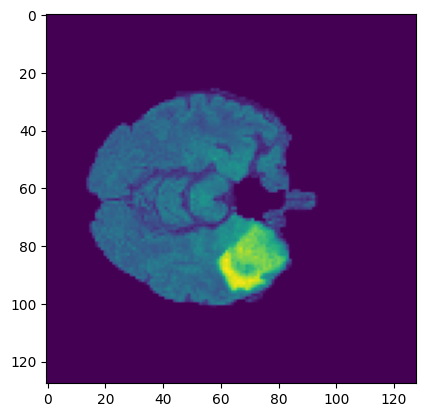

In [4]:
plt.imshow(test_data[50, :, :, 0])

In [5]:
trainer = pl.Trainer(logger=False, enable_checkpointing=False, max_epochs=1)
model = BaselineModel()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
trainer.fit(model, train_dataloaders=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/tmb2k01/deep_learning/.venv/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:182: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 0:   1%|          | 4/328 [00:01<01:56,  2.79it/s]                    

/home/tmb2k01/deep_learning/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/optimization/automatic.py:132: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 0: 100%|██████████| 328/328 [01:11<00:00,  4.59it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 328/328 [01:11<00:00,  4.59it/s]


In [7]:
output = model(test_data)

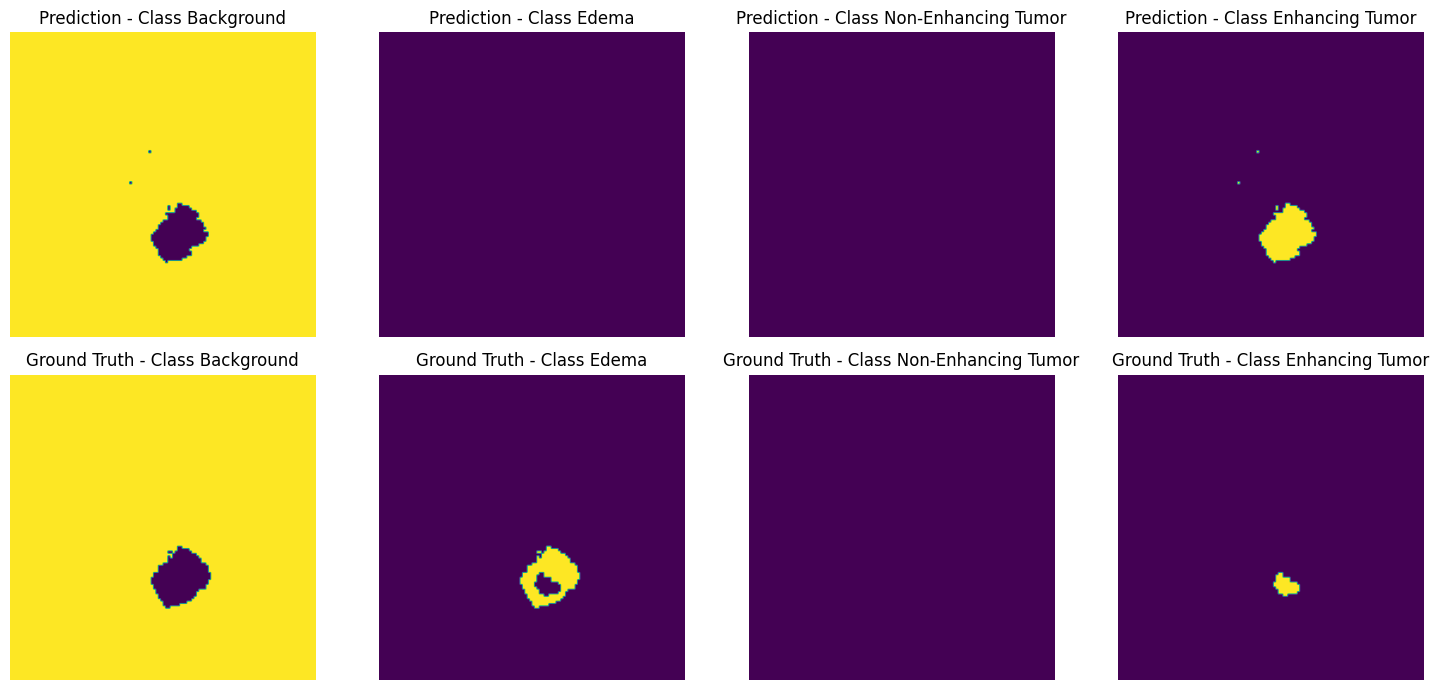

In [8]:
_, axs = plt.subplots(2, 4, figsize=(15, 7))

index_to_name = {
    0: "Background",
    1: "Edema",
    2: "Non-Enhancing Tumor",
    3: "Enhancing Tumor",
}

for class_index in range(4):
    axs[0, class_index].imshow(output[50, class_index, :, :])
    axs[0, class_index].set_title(f"Prediction - Class {index_to_name[class_index]}")
    axs[0, class_index].axis("off")

    axs[1, class_index].imshow(ground_truth[50, class_index, :, :])
    axs[1, class_index].set_title(f"Ground Truth - Class {index_to_name[class_index]}")
    axs[1, class_index].axis("off")

plt.tight_layout()
plt.show()

In [9]:
import torch

model.eval()

total_batches = len(data_module.test_dataloader())
num_classes = 4
height, width = 128, 128
slices_per_sample = 155

all_predictions = torch.empty(
    (total_batches, slices_per_sample, num_classes, height, width), dtype=torch.float32
)
all_targets = torch.empty(
    (total_batches, slices_per_sample, num_classes, height, width), dtype=torch.float32
)

for current_index, (images, targets) in enumerate(data_module.test_dataloader()):
    with torch.no_grad():
        predictions = model(images[0])
        all_predictions[current_index] = predictions
        all_targets[current_index] = targets[0]

print("Shape of all_predictions:", all_predictions.shape)
print("Shape of all_targets:", all_targets.shape)

Shape of all_predictions: torch.Size([59, 155, 4, 128, 128])
Shape of all_targets: torch.Size([59, 155, 4, 128, 128])


In [10]:
from metrics import *

dice_scores = dice_score(all_predictions, all_targets)
mean_dsc = mean_dice_score(dice_scores)
recall_scores, precision_scores = recall_precision(all_predictions, all_targets)
weighted_recall_score = weighted_recall(recall_scores, alpha=[0.2, 0.3, 0.5])

print("Dice Scores for each class:", dice_scores)
print("Mean Dice Score:", mean_dsc)
print("Recall Scores for each class:", recall_scores)
print("Precision Scores for each class:", precision_scores)
print("Weighted Recall:", weighted_recall_score)

Dice Scores for each class: [0.9884510636329651, 0.0, 0.0, 0.10151734203100204]
Mean Dice Score: 0.2724921014159918
Recall Scores for each class: [0.9834089279174805, 0.0, 0.0, 0.49919354915618896]
Precision Scores for each class: [0.9935451149940491, 0.0, 0.0, 0.056504081934690475]
Weighted Recall: 0.24959677457809448


In [ ]:
confusion_matrix = compute_confusion_matrix(all_predictions, all_targets)
df = pd.DataFrame(
    confusion_matrix, columns=index_to_name.values(), index=index_to_name.values()
)
print(df)

                     Background  Edema  Non-Enhancing Tumor  Enhancing Tumor
Background            145501255      0                    0          2454758
Edema                    544054      0                    0           552322
Non-Enhancing Tumor      209343      0                    0           186782
Enhancing Tumor          191892      0                    0           191274
